# Klasifikasi Lokasi Foto CIT Menggunakan Pretrain Google ViT Model


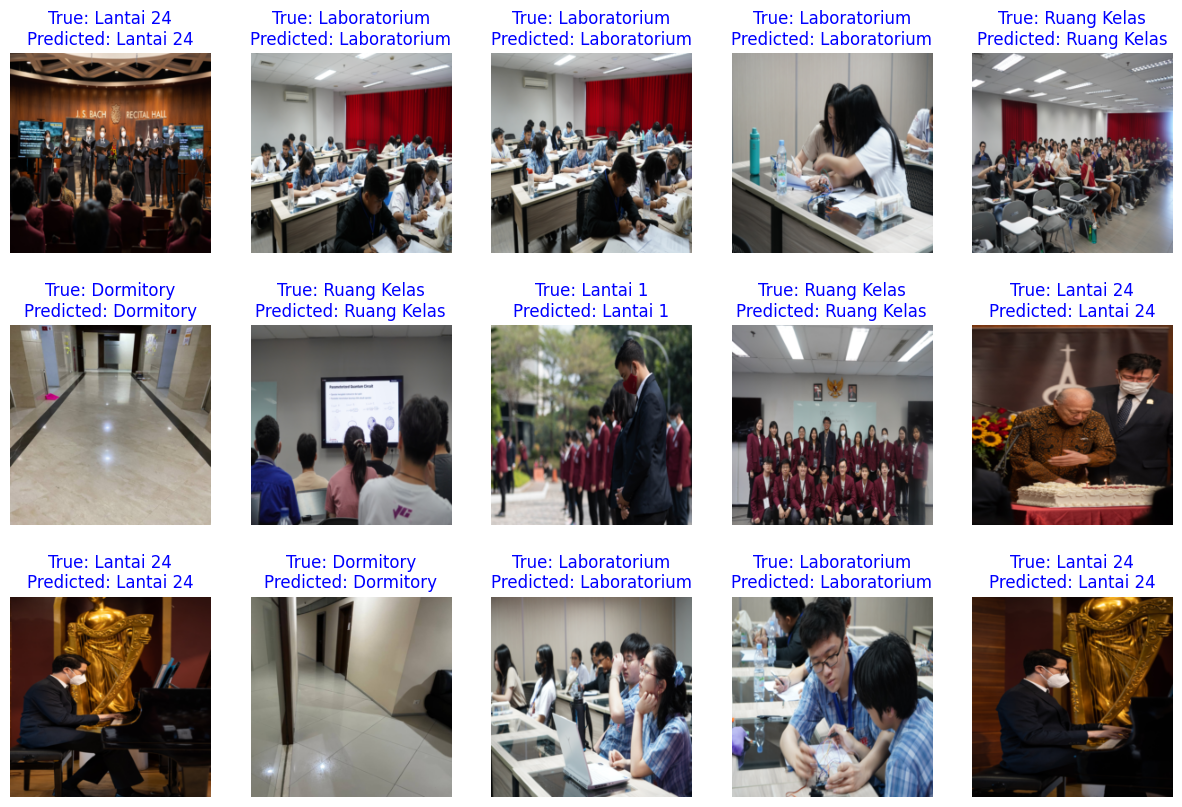

# Pendahuluan





## Latar Belakang Masalah

Ketika CIT menyelenggarakan suatu acara, tim dokumentasi mengambil banyak foto di berbagai ruangan yang kemudian tercampur dalam satu folder. Dalam proses membuat postingan IG, tim editor CR sering kesulitan menemukan gambar yang diinginkan karena penyimpanannya tidak teratur. Oleh karena itu, kami bermaksud membuat model yang dapat secara otomatis mengklasifikasikan lokasi foto, membantu merapihkan penyimpanan foto, dan memudahkan tim editor CR dalam mencari gambar yang dibutuhkan.


## Sumber data:



*   Seminar HIMA: https://drive.google.com/drive/u/1/folders/1owMZhV8jqr-emKXtAMdxk37WjGm_nDvd
*   Lomba IBDA: https://drive.google.com/drive/folders/1iGNlsHjp6EyD29KWupuj5rQ0hwG_sPf5 (dilabeli oleh James)
*   CITMO: https://drive.google.com/drive/u/1/folders/1VKm85I-0mipbjo_gKFGgZ-ddtkkEGDG- (dilabeli oleh Jason)
*   Christmas Memory:  https://drive.google.com/drive/u/1/folders/1KnhHAE8HsOq_DJl9iokSJmNZpgUyR2oM (dilabeli oleh Noel)
*   Foto dari group telegram dormitory (dilabeli oleh Stefannus)
*   Foto ruangan-ruangan CIT tanpa orang


## Cara memperoleh data:

Dataset kami peroleh dari dari kumpulan foto event yang sudah berlalu dan foto ruangan yang kami ambil sendiri. Kemudian, kami bagi tugas untuk melabeli data tersebut.

Sejauh ini kami ingin mengklasifikasi foto menjadi beberapa kelas sebagai berikut:

* Ruang Kelas
* Laboratorium
* Dinning Hall
* Lt24
* Lt 1
* Common area
* Lapangan Basket
* Dormitory


## Jenis model computer vision yang digunakan:

Kami akan mencoba model transformer dari huggingface https://huggingface.co/google/vit-base-patch16-224. yang di finetuning dengan dataset yang kami buat.



# Pembahasan Model



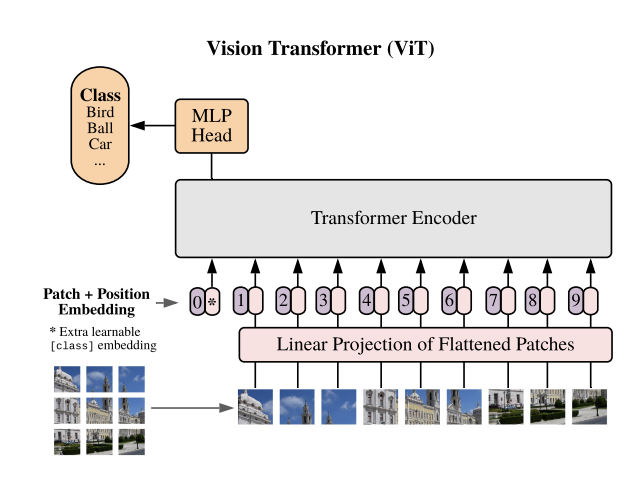


Vision Transformer (ViT) adalah model transformer encoder (seperti BERT) yang dilatih sebelumnya pada kumpulan besar gambar supervised, yaitu ImageNet-21k, pada resolusi 224x224 piksel. Selanjutnya, model tersebut fine-tuned di ImageNet (juga disebut sebagai ILSVRC2012), dataset yang terdiri dari 1 juta gambar dan 1.000 kelas, juga pada resolusi 224x224.

Gambar disajikan ke model sebagai rangkaian dari fixed-size patches (resolusi 16x16), yang linearly embedded. Juga ditambahkan token [CLS] ke awal urutan untuk menggunakannya dalam tugas klasifikasi. Juga ditambahkan absolute position embeddings sebelum memasukkan urutan ke lapisan encoder Transformer.

Dengan melakukan pra-training pada model, model tersebut mempelajari representasi bagian dalam gambar yang kemudian dapat digunakan untuk mengekstrak fitur yang berguna untuk downstream task: misalnya jika kita memiliki kumpulan data gambar berlabel, kita dapat melatih pengklasifikasi standar dengan menempatkan lapisan linier pada bagian atas encoder terlatih. Seseorang biasanya menempatkan lapisan linier di atas token [CLS], karena keadaan tersembunyi terakhir dari token ini dapat dilihat sebagai representasi dari keseluruhan gambar.

### Penggunakan
Model ini digunakan untuk klasifikasi gambar.

### Prosedur Training

**Preprocessing** <br>

Gambar diresize/rescaled ulang ke resolusi yang sama (224x224) dan dinormalisasi di seluruh saluran RGB dengan mean (0,5, 0,5, 0,5) dan deviasi standar (0,5, 0,5, 0,5).

**Pretraining** <br>
Model ini dilatih pada perangkat keras TPUv3 (8 core). Semua varian model dilatih dengan ukuran batch 4096 dan learning rate warmup dari 10k steps. Untuk ImageNet, penulis merasa bermanfaat untuk menerapkan tambahan kliping gradien pada norma global 1. Resolusi pelatihan adalah 224.

**Evaluation results** <br>
Untuk hasil evaluasi beberapa tolak ukur klasifikasi gambar, kami mengacu pada tabel 2 dan 5 original paper. Perhatikan bahwa untuk fine tuning, hasil terbaik diperoleh dengan resolusi lebih tinggi (384x384). Tentu saja, memperbesar ukuran model akan menghasilkan performa yang lebih baik.

**Referensi** <br>
* Wu, Bichen, Chenfeng Xu, Xiaoliang Dai, Alvin Wan, Peizhao Zhang, Zhicheng Yan, Masayoshi Tomizuka, Joseph Gonzalez, Kurt Keutzer, dan Peter Vajda. "Visual Transformers: Token-based Image Representation and Processing for Computer Vision." 2020. eprint: 2006.03677. arXiv, primaryClass: cs.CV.
* Deng, Jia, Wei Dong, Richard Socher, Li-Jia Li, Kai Li, dan Li Fei-Fei. "Imagenet: A large-scale hierarchical image database." Dalam 2009 IEEE conference on computer vision and pattern recognition, hal. 248-255. 2009. IEEE.


# Pembuatan Model


## Import Library


In [ ]:
import os
import torch
import random
import joblib
import torch
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from transformers import ViTFeatureExtractor, ViTForImageClassification
from torch.utils.data import DataLoader, Dataset
from torch import nn, optim
from torchvision import models, transforms
from PIL import Image
from random import randint
from tqdm import tqdm
from google.colab import drive

## Load Dataset



In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd /content/drive/MyDrive/Kuliah/CV/Dataset UAS CV

/content/drive/.shortcut-targets-by-id/1vjPAc5HuaOBWq3hgoo4rHhaSWzHKaTuZ/Dataset UAS CV


In [ ]:
main_directory = "/content/drive/MyDrive/Kuliah/CV/Dataset UAS CV"
data = []

for class_folder in os.listdir(main_directory):
    if class_folder == "Demo" : continue
    class_path = os.path.join(main_directory, class_folder)
    if os.path.isdir(class_path):
        for filename in os.listdir(class_path):
            data.append({"path": os.path.join(class_path, filename), "class_name": class_folder})
df_all = pd.DataFrame(data)
print(df_all)


                                                   path       class_name
0     /content/drive/MyDrive/Kuliah/CV/Dataset UAS C...  Lapangan Basket
1     /content/drive/MyDrive/Kuliah/CV/Dataset UAS C...  Lapangan Basket
2     /content/drive/MyDrive/Kuliah/CV/Dataset UAS C...  Lapangan Basket
3     /content/drive/MyDrive/Kuliah/CV/Dataset UAS C...  Lapangan Basket
4     /content/drive/MyDrive/Kuliah/CV/Dataset UAS C...  Lapangan Basket
...                                                 ...              ...
3695  /content/drive/MyDrive/Kuliah/CV/Dataset UAS C...      Ruang Kelas
3696  /content/drive/MyDrive/Kuliah/CV/Dataset UAS C...      Ruang Kelas
3697  /content/drive/MyDrive/Kuliah/CV/Dataset UAS C...      Ruang Kelas
3698  /content/drive/MyDrive/Kuliah/CV/Dataset UAS C...      Ruang Kelas
3699  /content/drive/MyDrive/Kuliah/CV/Dataset UAS C...      Ruang Kelas

[3700 rows x 2 columns]


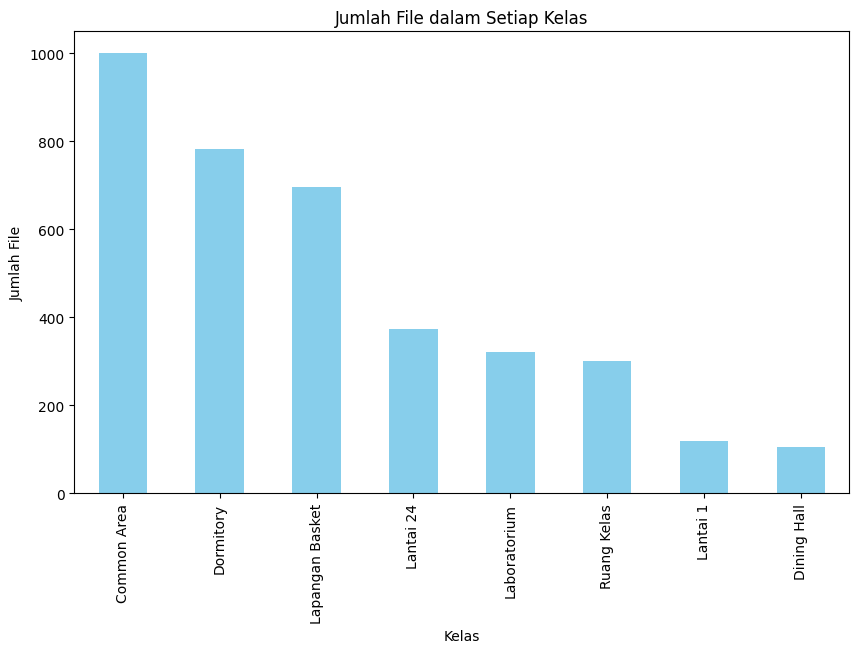

In [ ]:
class_counts = df_all['class_name'].value_counts()
plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar', color='skyblue')
plt.title('Jumlah File dalam Setiap Kelas')
plt.xlabel('Kelas')
plt.ylabel('Jumlah File')
plt.show()


Karena data tidak seimbang jumlahnya, diputuskan untuk mengambil maksimal 100 gambar perkelas

In [ ]:
main_directory = "/content/drive/MyDrive/Kuliah/CV/Dataset UAS CV"
data = []
class_counts = {}
max_images_per_class = 100

for class_folder in os.listdir(main_directory):
    if class_folder == "Demo" : continue
    class_path = os.path.join(main_directory, class_folder)
    if os.path.isdir(class_path):
        class_counts[class_folder] = 0
        for filename in os.listdir(class_path):
            if class_counts[class_folder] >= max_images_per_class:
                break
            data.append({"path": os.path.join(class_path, filename), "class_name": class_folder})
            class_counts[class_folder] += 1

df = pd.DataFrame(data)
label_encoder = LabelEncoder()
df['class'] = label_encoder.fit_transform(df['class_name'])
joblib.dump(label_encoder, 'label_encoder.pkl') # Simpan Encoder untuk dipake nanti
df


,path,class_name,class
0,/content/drive/MyDrive/Kuliah/CV/Dataset UAS C...,Lapangan Basket,6
1,/content/drive/MyDrive/Kuliah/CV/Dataset UAS C...,Lapangan Basket,6
2,/content/drive/MyDrive/Kuliah/CV/Dataset UAS C...,Lapangan Basket,6
3,/content/drive/MyDrive/Kuliah/CV/Dataset UAS C...,Lapangan Basket,6
4,/content/drive/MyDrive/Kuliah/CV/Dataset UAS C...,Lapangan Basket,6
...,...,...,...
795,/content/drive/MyDrive/Kuliah/CV/Dataset UAS C...,Ruang Kelas,7
796,/content/drive/MyDrive/Kuliah/CV/Dataset UAS C...,Ruang Kelas,7
797,/content/drive/MyDrive/Kuliah/CV/Dataset UAS C...,Ruang Kelas,7
798,/content/drive/MyDrive/Kuliah/CV/Dataset UAS C...,Ruang Kelas,7


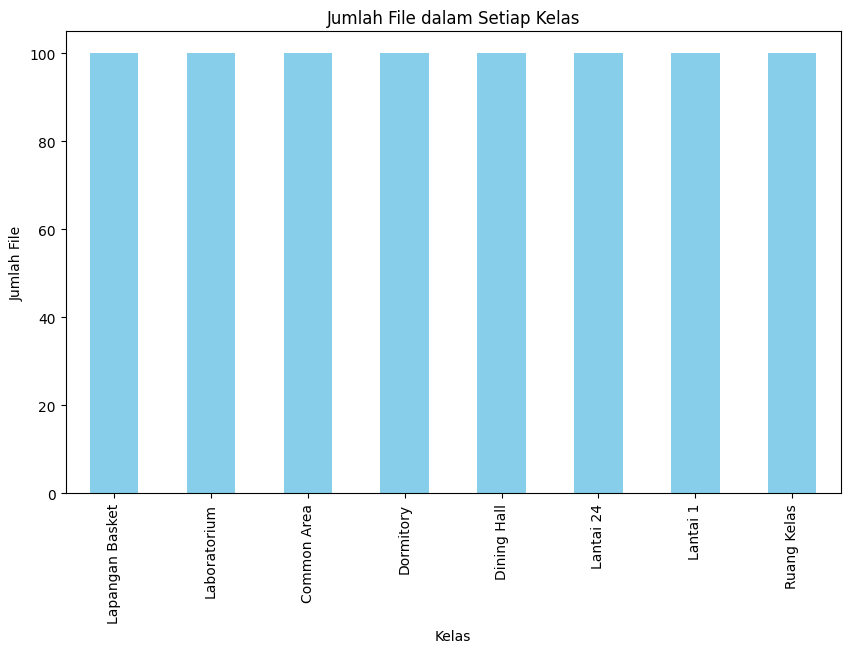

In [ ]:
class_counts = df['class_name'].value_counts()
plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar', color='skyblue')
plt.title('Jumlah File dalam Setiap Kelas')
plt.xlabel('Kelas')
plt.ylabel('Jumlah File')
plt.show()

Dataset yang ada ternyata tidak memiliki gambar di perpustakaan sehingga **total kelas ada 7**. Data kemudian dipisahkan menjadi data menjadi 80% untuk training dan 20% untuk data test/validation

In [ ]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

## Persiapan Dataset
*   Class CustomDataset dibuat untuk membaca path dari dataframe kemudian meload gambar dan mentransformasikannya kebentuk 224x224.

In [ ]:

class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image_path = self.dataframe.iloc[idx]['path']
        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        label = torch.tensor(self.dataframe.iloc[idx]['class'], dtype=torch.long)
        return {'image': image, 'label': label}


In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_dataset = CustomDataset(train_df, transform=transform)
val_dataset = CustomDataset(val_df, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


## Persiapan Model
*  Pretrain model diambil dari huggingface https://huggingface.co/google/vit-base-patch16-224
*  Output layer disesuaikan dengan jumlah kelas yang diklasifikasi (8)

In [ ]:
num_classes = 8
model_name = 'google/vit-base-patch16-224'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name)
model = ViTForImageClassification.from_pretrained(model_name)
model.classifier = torch.nn.Linear(model.config.hidden_size, num_classes)
model.config.num_labels = num_classes

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

**Arsitektur Model:**

In [ ]:
print(model)

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

### Finetuned Model

* Optimizer menggunakan Adam dengan parameter dari pretrain sebelumnya
* Jenis loss function yang digunakan adalah Cross Entropy karena kasusnya adalah klasifikasi multi kelas.
* Pelatihan dilakukan menggunakan GPU agar lebih cepat
* Karena ini hanya finetune dari model yang sudah bagus, pemilihan epoch juga tidak perlu banyak, yaitu 10

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Set up the optimizer and loss function
optimizer = optim.AdamW(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

# Training history
train_loss_history = []
train_accuracy_history = []
val_loss_history = []
val_accuracy_history = []

# Training loop
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_preds = []
    train_labels = []

    tqdm_train_loader = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}', dynamic_ncols=True)

    for batch in tqdm_train_loader:
        inputs = batch['image'].to(device)
        labels = batch['label'].to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs.logits, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        # For accuracy calculation
        train_preds.extend(torch.argmax(outputs.logits, dim=1).cpu().numpy())
        train_labels.extend(labels.cpu().numpy())

    average_train_loss = train_loss / len(train_loader)
    train_accuracy = accuracy_score(train_labels, train_preds)

    tqdm_train_loader.set_postfix(train_loss=average_train_loss, train_accuracy=train_accuracy)

    # Validation
    model.eval()
    val_loss = 0.0
    val_preds = []
    val_labels = []

    tqdm_val_loader = tqdm(val_loader, desc=f'Validation', dynamic_ncols=True)

    with torch.no_grad():
        for batch in tqdm_val_loader:
            inputs = batch['image'].to(device)
            labels = batch['label'].to(device)

            outputs = model(inputs)
            loss = criterion(outputs.logits, labels)
            val_loss += loss.item()

            # For accuracy calculation
            val_preds.extend(torch.argmax(outputs.logits, dim=1).cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    average_val_loss = val_loss / len(val_loader)
    val_accuracy = accuracy_score(val_labels, val_preds)

    tqdm_val_loader.set_postfix(val_loss=average_val_loss, val_accuracy=val_accuracy)

    # Save history
    train_loss_history.append(average_train_loss)
    train_accuracy_history.append(train_accuracy)
    val_loss_history.append(average_val_loss)
    val_accuracy_history.append(val_accuracy)

# Save the fine-tuned model if necessary
torch.save(model.state_dict(), 'fine_tuned_model2.pth')

Validation: 100%|██████████| 5/5 [00:37<00:00,  7.55s/it]


### Plot History Finetuned Model


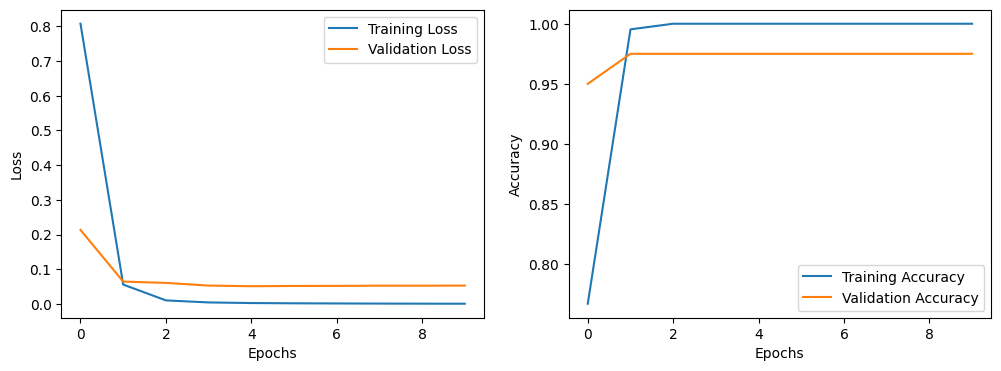

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy_history, label='Training Accuracy')
plt.plot(val_accuracy_history, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Dapat dilihat bahwa model mencapai akurasi yang terbaik pada epoch ke-1, setelah itu tidak ada perubahan lagi.

### Evaluasi Model


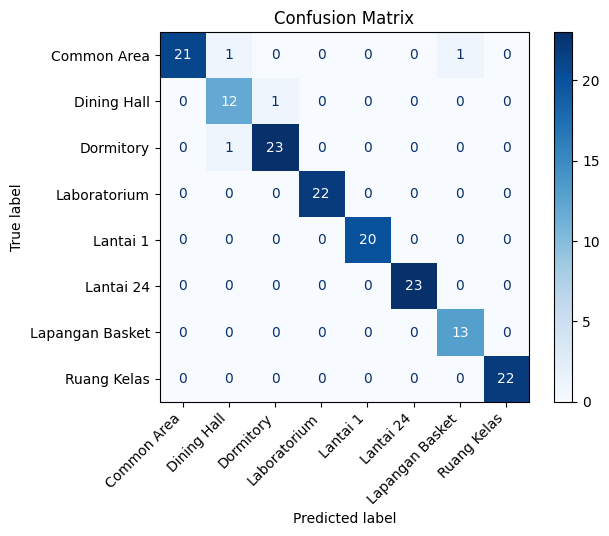

In [ ]:
test_loader = val_loader
test_dataset = val_dataset

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        inputs = batch['image'].to(device)
        labels = batch['label'].to(device)

        outputs = model(inputs)
        preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()

        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

conf_matrix = confusion_matrix(all_labels, all_preds)
class_names = label_encoder.classes_

disp = ConfusionMatrixDisplay(conf_matrix, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.xticks(rotation=45, ha='right')
plt.show()


In [ ]:
class_report = classification_report(all_labels, all_preds, target_names=label_encoder.classes_)
print(class_report)

                 precision    recall  f1-score   support

    Common Area       1.00      0.91      0.95        23
    Dining Hall       0.86      0.92      0.89        13
      Dormitory       0.96      0.96      0.96        24
   Laboratorium       1.00      1.00      1.00        22
       Lantai 1       1.00      1.00      1.00        20
      Lantai 24       1.00      1.00      1.00        23
Lapangan Basket       0.93      1.00      0.96        13
    Ruang Kelas       1.00      1.00      1.00        22

       accuracy                           0.97       160
      macro avg       0.97      0.97      0.97       160
   weighted avg       0.98      0.97      0.98       160



In [ ]:
# Calculate overall accuracy
total_correct = sum(conf_matrix[i][i] for i in range(len(conf_matrix)))
total_samples = sum(sum(row) for row in conf_matrix)

overall_accuracy = total_correct / total_samples if total_samples > 0 else 0

print(f'Overall Accuracy: {overall_accuracy * 100:.2f}%')

class_names = label_encoder.classes_

class_accuracies = []
class_counts = []

for i in range(len(class_names)):
    class_count = sum(conf_matrix[i])
    class_accuracy = conf_matrix[i][i] / class_count if class_count > 0 else 0
    class_accuracies.append(class_accuracy)
    class_counts.append(class_count)

accuracy_df = pd.DataFrame({
    'Class': class_names,
    'Accuracy': class_accuracies,
    'Class_Count': class_counts
})

accuracy_df

Overall Accuracy: 97.50%


,Class,Accuracy,Class_Count
0,Common Area,0.913043,23
1,Dining Hall,0.923077,13
2,Dormitory,0.958333,24
3,Laboratorium,1.000000,22
4,Lantai 1,1.000000,20
5,Lantai 24,1.000000,23
6,Lapangan Basket,1.000000,13
7,Ruang Kelas,1.000000,22


In [ ]:
# Calculate overall accuracy
total_correct = sum(conf_matrix[i][i] for i in range(len(conf_matrix)))
total_samples = sum(sum(row) for row in conf_matrix)

overall_accuracy = total_correct / total_samples if total_samples > 0 else 0

print(f'Overall Accuracy: {overall_accuracy * 100:.2f}%')

Overall Accuracy: 97.50%


Dapat dilihat bahwa model ini dapat mempresiksi data validasi dengan sangat baik dengan akurasi 97.5%. Namun, model ini sedikit kurang tepat dalam mengklasifikasi beberapa foto Common Area, Dinning Hall dan Dormitory.

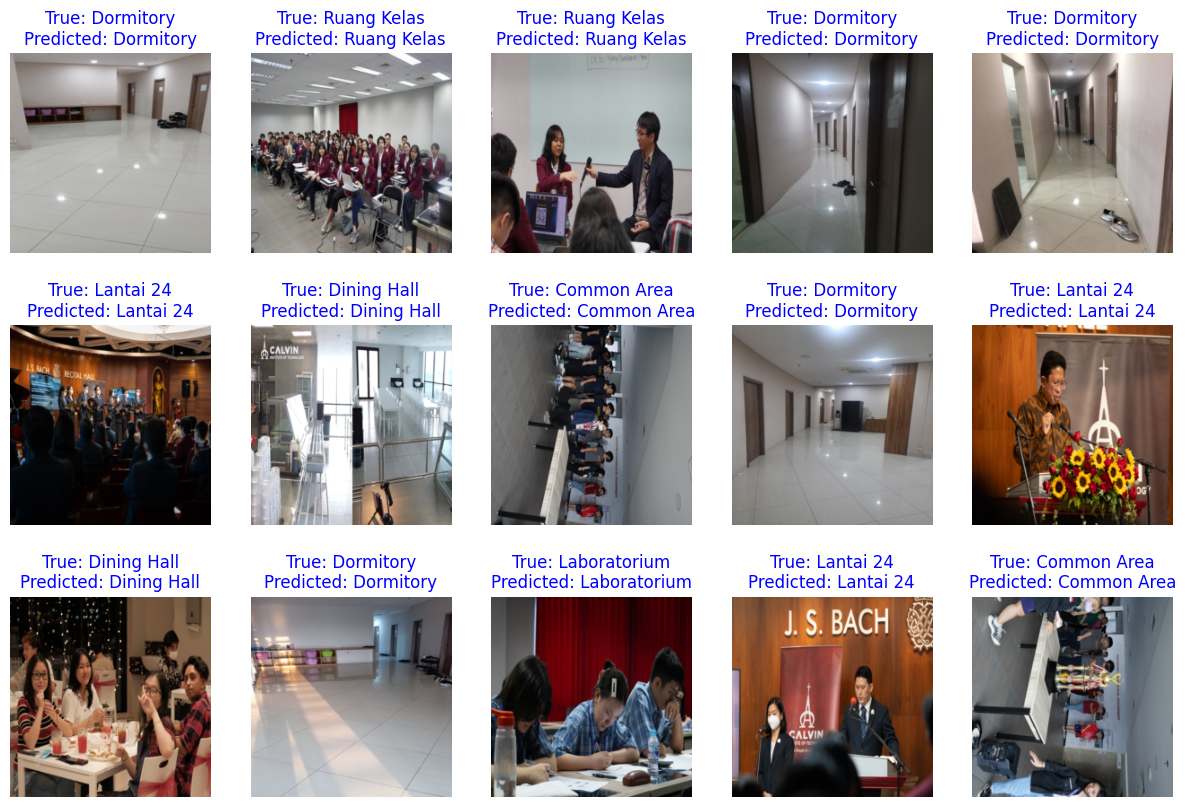

In [ ]:
test_dataset = val_dataset
class_names = label_encoder.classes_

model.eval()
sample_images = []
sample_labels = []
sample_predictions = []

with torch.no_grad():
    for batch in test_loader:
        inputs = batch['image'].to(device)
        labels = batch['label'].to(device)

        outputs = model(inputs)
        preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()

        sample_images.extend(inputs.cpu().numpy())
        sample_labels.extend(labels.cpu().numpy())
        sample_predictions.extend(preds)

# Randomly select 15 samples
random_indices = random.sample(range(len(sample_images)), 15)

plt.figure(figsize=(15, 10))
for i, idx in enumerate(random_indices, 1):
    plt.subplot(3, 5, i)
    plt.imshow(sample_images[idx].transpose((1, 2, 0)))  # Transpose to (H, W, C)
    true_label = class_names[sample_labels[idx]]
    pred_label = class_names[sample_predictions[idx]]
    color = 'blue' if true_label == pred_label else 'red'
    plt.title(f'True: {true_label}\nPredicted: {pred_label}', color=color)
    plt.axis('off')

plt.show()


### Evaluasi ke data keseluruhan

In [ ]:
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for _, row in tqdm(df_all.iterrows(), total=len(df_all), desc="Evaluating"):
        image_path = row['path']
        true_label = row['class_name']

        image = Image.open(image_path).convert('RGB')
        image = transform(image)
        image = image.unsqueeze(0)

        outputs = model(image)
        preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()

        all_preds.append(preds[0])
        all_labels.append(label_encoder.transform([true_label])[0])

conf_matrix = confusion_matrix(all_labels, all_preds)
class_report = classification_report(all_labels, all_preds, target_names=label_encoder.classes_)

print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)


Evaluating: 100%|██████████| 3700/3700 [1:17:33<00:00,  1.26s/it]

Confusion Matrix:
[[771  37   2   0  16   0 145  29]
 [  0 104   1   0   0   0   0   0]
 [  7  20 748   1   2   1   2   1]
 [ 10   7   1 259   9   0   0  36]
 [  0   0   0   0 120   0   0   0]
 [  0   0   0   0   1 372   0   1]
 [  5   3   0   0  41   0 647   0]
 [  6   1   0   6   0   0   0 288]]

Classification Report:
                 precision    recall  f1-score   support

    Common Area       0.96      0.77      0.86      1000
    Dining Hall       0.60      0.99      0.75       105
      Dormitory       0.99      0.96      0.98       782
   Laboratorium       0.97      0.80      0.88       322
       Lantai 1       0.63      1.00      0.78       120
      Lantai 24       1.00      0.99      1.00       374
Lapangan Basket       0.81      0.93      0.87       696
    Ruang Kelas       0.81      0.96      0.88       301

       accuracy                           0.89      3700
      macro avg       0.85      0.93      0.87      3700
   weighted avg       0.91      0.89      0.90  

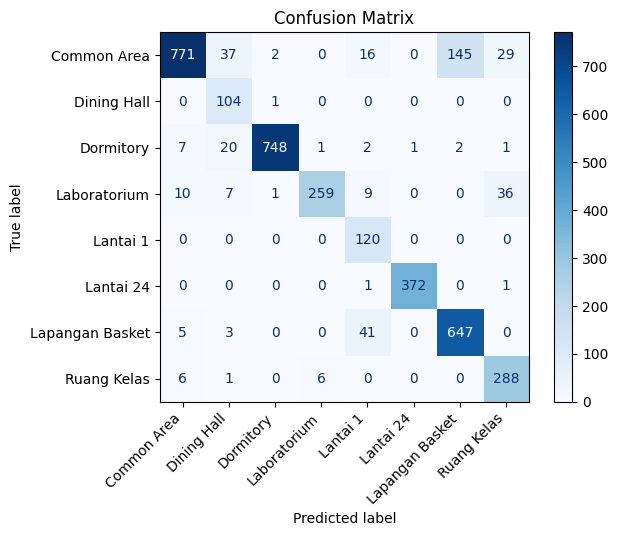

In [ ]:
# Display the confusion matrix
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.xticks(rotation=45, ha='right')
plt.show()

In [ ]:
# Calculate overall accuracy
total_correct = sum(conf_matrix[i][i] for i in range(len(conf_matrix)))
total_samples = sum(sum(row) for row in conf_matrix)

overall_accuracy = total_correct / total_samples if total_samples > 0 else 0

print(f'Overall Accuracy: {overall_accuracy * 100:.2f}%')

Overall Accuracy: 89.43%


In [ ]:
# Calculate overall accuracy
total_correct = sum(conf_matrix[i][i] for i in range(len(conf_matrix)))
total_samples = sum(sum(row) for row in conf_matrix)

overall_accuracy = total_correct / total_samples if total_samples > 0 else 0

print(f'Overall Accuracy: {overall_accuracy * 100:.2f}%')

class_names = label_encoder.classes_

class_accuracies = []
class_counts = []

for i in range(len(class_names)):
    class_count = sum(conf_matrix[i])
    class_accuracy = conf_matrix[i][i] / class_count if class_count > 0 else 0
    class_accuracies.append(class_accuracy)
    class_counts.append(class_count)

accuracy_df = pd.DataFrame({
    'Class': class_names,
    'Accuracy': class_accuracies,
    'Class_Count': class_counts
})

accuracy_df

,Class,Accuracy,Class_Count
0,Common Area,0.771000,1000
1,Dining Hall,0.990476,105
2,Dormitory,0.956522,782
3,Laboratorium,0.804348,322
4,Lantai 1,1.000000,120
5,Lantai 24,0.994652,374
6,Lapangan Basket,0.929598,696
7,Ruang Kelas,0.956811,301


## Kesimpulan
*  Model yang dihasilkan memiliki akurasi 97.5% pada data validasi dan 89.4% pada keseluruhan dataset.
*  Pada data validasi model ini dapat mengklasifikasi semua lokasi dengan tepat kecuali beberapa foto Common Area, Dinning Hall dan Dormitory.
*  Pada data keseluruhan, Akurasi 100% ditapatkan untuk klasifikasi Lantai 1,sedangkan akurasi terburuk adalah 77% untuk klasifikasi Common Area.

# Demo
1.   Ambil model google/vit-base-patch16-224 dari hugging face.
2.   Ambil weight dari fine tune sebelumnya (fine_tuned_model.pth)
3.   Ambil label encoder ('label_encoder.pkl')
4.   Coba prediksi gambar random
5.   Demo gunakan model untuk mengklasifikasi semua gambar yang tercampur dalam satu folder dan memisahkannya kedalam folder-folder sesuai lokasinya.

In [ ]:
model_name = 'google/vit-base-patch16-224'
num_classes = 8
feature_extractor = ViTFeatureExtractor(model_name)
model = ViTForImageClassification.from_pretrained(model_name)
model.classifier = torch.nn.Linear(model.config.hidden_size, num_classes)
model.config.num_labels = num_classes

# Muat state_dict dari model yang telah dilatih
model.load_state_dict(torch.load('fine_tuned_model2.pth', map_location='cpu'))
model.eval()

# Memuat preprocessing (Label Encoder)
label_encoder = joblib.load('label_encoder2.pkl')

# Membuat transformasi yang sesuai dengan yang digunakan selama pelatihan
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

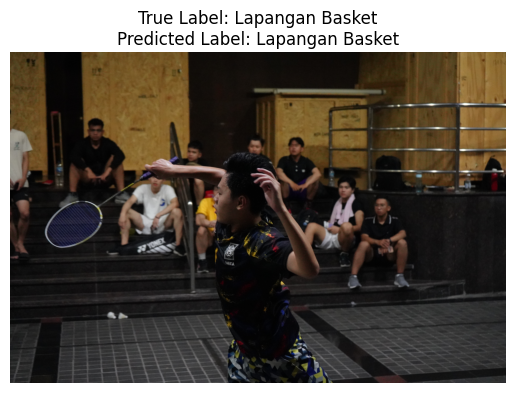

In [ ]:
# @title Coba prediksi gambar random
# Menggunakan model dan preprocessing pada data baru
idx = randint(0,487)
image_path = df_all["path"][idx]  # Gantilah ini dengan path gambar Anda
true_label = df_all["class_name"][idx]
image = Image.open(image_path).convert('RGB')
image = transform(image)
image = image.unsqueeze(0)  # Menambahkan dimensi batch

# Menerapkan model
with torch.no_grad():
    output = model(image)

# Mengambil prediksi dan menerapkan label_encoder
prediction = torch.argmax(output.logits, dim=1).item()
predicted_class = label_encoder.classes_[prediction]

# Menampilkan gambar, label, dan hasil klasifikasi
image = Image.open(image_path).convert('RGB')
plt.imshow(image)
plt.title(f'True Label: {true_label}\nPredicted Label: {predicted_class}')
plt.axis('off')
plt.show()

In [ ]:
!pip install pyheif

In [ ]:
# @title  Demo gunakan model untuk mengklasifikasi semua gambar yang tercampur dalam satu folder dan memisahkannya kedalam folder-folder sesuai lokasinya.

import os
import shutil
from tqdm import tqdm
from PIL import Image
import torch

# Import module pyheif
import pyheif

def create_directory(directory):
    os.makedirs(directory, exist_ok=True)

def copy_image_to_desired_folder(class_name, directory, image_path):
    predicted_class_directory = os.path.join(directory, class_name)
    create_directory(predicted_class_directory)
    shutil.copy(image_path, predicted_class_directory)

main_directory = "Demo"
uncategorized_path = os.path.join(main_directory, "Uncategorized")

for image_name in tqdm(os.listdir(uncategorized_path)):
    image_path = os.path.join(uncategorized_path, image_name)

    if image_name.lower().endswith(('.heic')):
        heif_file = pyheif.read(image_path)
        image = Image.frombytes(
            heif_file.mode,
            heif_file.size,
            heif_file.data,
            "raw",
            heif_file.mode,
            heif_file.stride,
        )
    else:
        image = Image.open(image_path).convert('RGB')

    image = transform(image)
    image = image.unsqueeze(0)

    with torch.no_grad():
        output = model(image)

    prediction = torch.argmax(output.logits, dim=1).item()
    predicted_class = label_encoder.classes_[prediction]

    copy_image_to_desired_folder(predicted_class, main_directory, image_path)


100%|██████████| 95/95 [02:36<00:00,  1.65s/it]
